# ML for science - Unfold
## Baudoin von Sury - Pierre Vuillecard - Hugo Birch

## This notebook present the prediction of kinematic from average CP and average CL

We used the sklearn python librairy (https://scikit-learn.org) to perform different regression on our data. And we used keras python library (https://keras.io/) to implement the different neural networks

- Part 1 : Implement linear regression to approximate the optimal solution of CL average and efficiency.
- Part 2 : Use some points of the pareto approximation to predict kinematic alphas.
- Part 3 : Repredict CL mean and CP mean with the ridge regression found before.
- Part 4 : Replot the results


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pandas.compat import StringIO
from Load import*
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import probplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.activations import elu
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

from kinematic import *

np.random.seed(123)

In [80]:
path = os.getcwd()
path = path+ '/ml_data/complete/complete/'

In [81]:
N_EXP = 4100
# Load the data (CP and kinematic alphas for the N_EXP experiments)
CP = load_data(path,N_EXP, cl = False)
random_permuted_indices = np.random.permutation(N_EXP)
CP = CP[random_permuted_indices,:,:]
# Load the data (CL and kinematic alphas for the N_EXP experiments)
CL = load_data(path,N_EXP, cl = True)
CL = CL[random_permuted_indices,:,:]

# Part 1 : Implement linear regression to approximate the optimal solution of CL average and efficiency.

In [82]:
# Calculate the CP mean and CL mean for each experiment
CL_mean = np.mean(CL[:,1,:] , axis =1)
CP_mean = np.mean(CP[:,1,:] , axis =1)

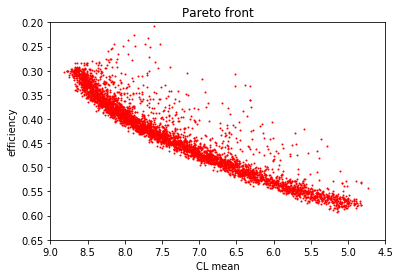

In [83]:
# Creation of the augmented features matrix in order to run the linear regression.
X = np.c_[np.ones((N_EXP,)),CL_mean, np.power(CL_mean,2)]
# Computation of the efficiency
efficiency = CL_mean / CP_mean

# Plot the pareto front
plt.figure()
plt.scatter(CL_mean , efficiency,c = 'red',s=1)
plt.title("Pareto front")
ax = plt.gca()
ax.set(xlim=(4.5, 9), ylim=(0.2, 0.65))
ax.invert_yaxis()
ax.invert_xaxis()
plt.xlabel("CL mean")
plt.ylabel("efficiency")
plt.show()

### Data points from the experiment where efficiency = CP/CP

In [84]:
# Run the linear regression on the pareto front plot
regr = linear_model.LinearRegression()
regr.fit(X, efficiency)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

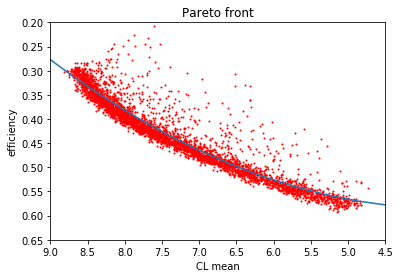

In [85]:
# Create the discrete data points to represent the approximation of the pareto
x = np.linspace(4,10,15)
X_test = np.c_[np.ones((15,)), x, np.power(x,2)]
# Compute the approximation
y = regr.predict(X_test)

# Plot the pareto front
plt.figure()
plt.scatter(CL_mean , efficiency,c = 'red',s=1)
plt.plot(x,y,label ='regression')
plt.title("Pareto front")
ax = plt.gca()
ax.set(xlim=(4.5, 9), ylim=(0.2, 0.65))
ax.invert_yaxis()
ax.invert_xaxis()
plt.xlabel("CL mean")
plt.ylabel("efficiency")
plt.show()

# Use some points of the pareto approximation to predict kinematic alphas.

### Using linear regression 

In [86]:
num_train = int(0.8*N_EXP)
X = np.c_[CL_mean,CP_mean]
Y= CL[:,0,:]

In [87]:
alphas = np.logspace(-6,6,20)
degree = [1,2,3]
rmse_te_deg ,rmse_tr_deg,best_alpha = cv_regularization_degree(X,Y,alphas,degree)

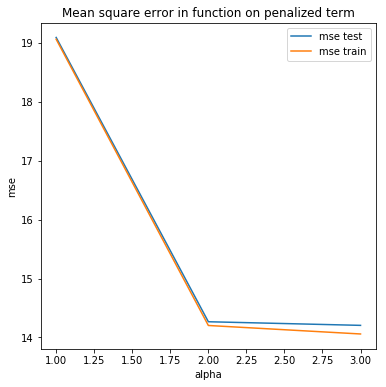

In [88]:
plt.figure(figsize=(6,6))
plt.plot(degree , rmse_te_deg, label = "mse test")
plt.plot(degree , rmse_tr_deg , label = "mse train")
plt.legend()
plt.title("Mean square error in function on penalized term")
plt.xlabel("alpha")
plt.ylabel("mse")
plt.show()

In [89]:
# Initialize the X matrix from the selected points of the pareto front to predict kinematics alphas
CL_test = x
CP_test = x/y
X_test_alpha = np.c_[CL_test,CP_test]

In [90]:
mse_te , mse_tr , alpha_LR = prediction( X, X_test_alpha, Y)

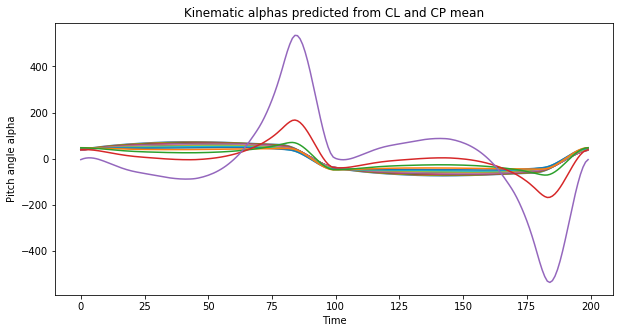

In [91]:
plt.figure(figsize = (10,5))
for i in range(15):
    plt.plot(alpha_LR[i,:])
plt.title("Kinematic alphas predicted from CL and CP mean")
plt.xlabel("Time")
plt.ylabel("Pitch angle alpha")
plt.savefig("predicted_alphas.jpg")
plt.show()

### The prediction of kinematic with linear regression outside of the boundaries (outside of the dataset) is terrible. Indeed, we can see on the plot above that a pitch angle of 400 does not make any sense. Maybe the neural networks perform way better ?

### Using Neural Networks 

In [92]:
# Split the data
num_train = int(0.8*N_EXP)
X = np.c_[scale(CL_mean,4,10),scale(CP_mean,8,40)]
#X = np.c_[CL_mean,CP_mean]

X_train = X[:num_train]
X_test = X[num_train:]
Y_train = CL[:num_train,0,:]
Y_test = CL[num_train:,0,:]
# build the model
model_averageC_to_alpha = build_averageC_to_alpha()
# Train the model
model_training2(model_averageC_to_alpha,X_train,X_test,Y_train,Y_test)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_37 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_38 (Dense)             (None, 200)               40200     
Total params: 81,000
Trainable params: 81,000
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00236: early stopping
Train: 14.349, Test: 15.425


(14.348809251552675, 15.424680588885051)

In [93]:
# Split the data
num_train = int(0.8*N_EXP)
#X = np.c_[scale(CL_mean,4,10),scale(CP_mean,8,40)]
X = np.c_[CL_mean,CP_mean]
X_train = X[:num_train]
X_test = X[num_train:]
Y_train = CL[:num_train,0,:]
Y_test = CL[num_train:,0,:]
model_averageC_to_alpha2 = build_averageC_to_alpha2()
model_training2(model_averageC_to_alpha2,X_train,X_test,Y_train,Y_test)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_40 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_41 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_42 (Dense)             (None, 200)               25800     
Total params: 36,328
Trainable params: 36,328
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00466: early stopping
Train: 19.253, Test: 18.828


(19.253144120007025, 18.828069026295733)

In [94]:
X = np.c_[CL_mean,CP_mean]
Y= CL[:,0,:]
train_mse,test_mse=cross_validation(build_averageC_to_alpha,X,Y,4 )
print(" the mse test of the cross validation is :" , test_mse)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_44 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_45 (Dense)             (None, 200)               40200     
Total params: 81,000
Trainable params: 81,000
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00522: early stopping
Train: 14.426, Test: 14.850
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_47 (Dense)             (N

In [96]:
X = np.c_[scale(CL_mean,4,10),scale(CP_mean,8,40)]
Y= CL[:,0,:]
train_mse_2,test_mse_2=cross_validation(build_averageC_to_alpha2,X,Y,4 )
print(" the mse test of the cross validation is :" , test_mse_2)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_56 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_57 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_58 (Dense)             (None, 200)               25800     
Total params: 36,328
Trainable params: 36,328
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00717: early stopping
Train: 13.414, Test: 13.887
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (N

In [98]:
# Initialize the X matrix from the selected points of the pareto front to predict kinematics alphas
CL_test = x
CP_test = x/y
X_test_alpha = np.c_[CL_test,CP_test]

In [99]:
# Predict new alphas from the selected points on the pareto front
new_alphas = model_averageC_to_alpha2.predict(X_test_alpha, verbose=0)

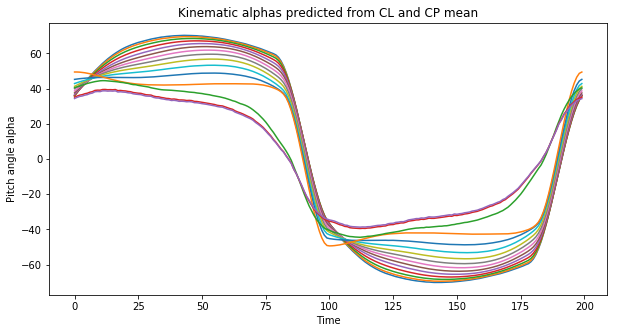

In [100]:
plt.figure(figsize = (10,5))
for alpha in new_alphas:
    plt.plot(alpha)
plt.title("Kinematic alphas predicted from CL and CP mean")
plt.xlabel("Time")
plt.ylabel("Pitch angle alpha")
plt.savefig("predicted_alphas.jpg")
plt.show()

### prediction of kinematics looks great and physically feasible even outside of the boundaries.

# Part 3 : Repredict CL mean and CP mean with the ridge regression found before.

In [101]:
# Optimal alpha for ridge regression to predict CP mean
alpha = 78.47599703514607
y = np.mean(CP[:,1,:] , axis = 1)
# Build the augmented matrix with x^2
X = np.c_[CP[:,0,:] , CP[:,0,:]**2]

# Split the data
num_train = int(0.8*N_EXP)
X_train = X[:num_train]
X_test = X[num_train:]
Y_train = y[:num_train]
Y_test = y[num_train:]

# Run the ridge regression
ridge_CP = Ridge(alpha=alpha,normalize=False)
ridge_CP.fit(X_train,Y_train)
y_pred = ridge_CP.predict(X_test)
mse = mean_squared_error(Y_test,y_pred)

In [102]:
# Optimal alpha for ridge regression to predict CL mean
alpha = 263.66
y = np.mean(CL[:,1,:] , axis = 1)
# Build the augmented matrix with x^2
X = np.c_[CL[:,0,:] , CL[:,0,:]**2]

# Split the data
num_train = int(0.9*N_EXP)
X_train = X[:num_train]
X_test = X[num_train:]
Y_train = y[:num_train]
Y_test = y[num_train:]

# Run the ridge regression
ridge_CL = Ridge(alpha=alpha,normalize=False)
ridge_CL.fit(X_train,Y_train)
y_pred = ridge_CL.predict(X_test)
mse = mean_squared_error(Y_test,y_pred)

In [103]:
# predict the efficiency using NN 
# Build the extended matrix of the alpha
X_new = np.c_[new_alphas,new_alphas**2]
# Prediction of CL_pred and CP_pred
CL_pred = ridge_CL.predict(X_new)
CP_pred = ridge_CP.predict(X_new)
# Computation of the predicted efficiency
eff_pred = CL_pred / CP_pred

# Part 4 : Replot the results

In [104]:
CP_pred_1 =np.loadtxt("CP_pred",delimiter=",")

In [105]:
CL_pred_1 = np.loadtxt("CL_pred",delimiter =",")

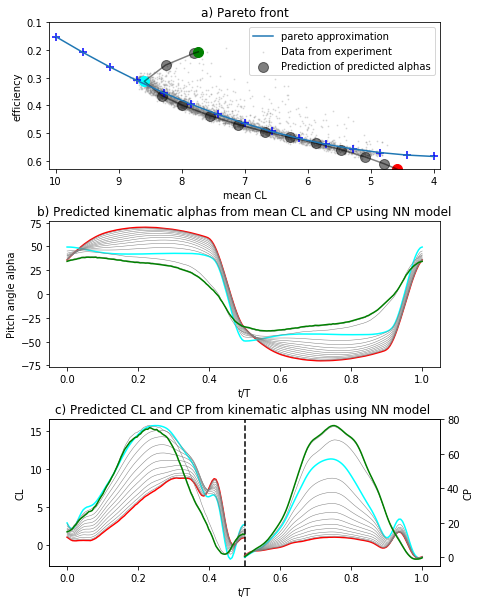

In [107]:
# discrete data points to represent the approximation of the pareto
x = np.linspace(4,10,15)
X_test = np.c_[np.ones((15,)), x, np.power(x,2)]
y = regr.predict(X_test)

# Plot of the results
plt.figure(figsize=(7,10))

plt.subplot(3,1,1)
plt.subplots_adjust(hspace=0.35)

plt.plot(CL_pred, eff_pred,c='black',alpha=0.5)
plt.scatter(CL_mean , efficiency,label ='Data from experiment',c = 'gray',s=1,alpha=0.2)
plt.scatter(CL_pred[0] , eff_pred[0],c = 'red',s=100,marker = 'o')
plt.scatter(CL_pred[11] , eff_pred[11],c = 'cyan',s=100,marker = 'o')
plt.scatter(CL_pred[1:11] , eff_pred[1:11], c = 'black',s=100,marker = 'o',alpha=0.5)
plt.scatter(CL_pred[12:14] , eff_pred[12:14], label ='Prediction of predicted alphas', c = 'black',s=100,marker = 'o',alpha=0.5)
plt.scatter(CL_pred[14] , eff_pred[14],c = 'green',s=100,marker = 'o')
#plt.scatter(CL_pred , eff_pred,label ='Prediction of predicted alphas',c = 'black',s=50,marker = 'o')
plt.plot(x,y,label ='pareto approximation')
plt.scatter(x,y ,c = 'blue',s=50,marker="+")
ax = plt.gca()
ax.set(xlim=(3.9, 10.1), ylim=(0.1, 0.63))
ax.invert_yaxis()
ax.invert_xaxis()
plt.ylabel('efficiency')
plt.xlabel('mean CL')
plt.title('a) Pareto front')
plt.legend()

plt.subplot(3,1,2)
x = np.linspace(0,1,200)
plt.plot(x ,new_alphas[0,:],c='red')
plt.plot(x ,new_alphas[11,:],c='cyan')
for i in range(1,11):
    plt.plot(x ,new_alphas[i,:],c='gray',linewidth = '0.5')
for i in range(12,14):
    plt.plot(x ,new_alphas[i,:],c='gray',linewidth = '0.5')
plt.plot(x,new_alphas[14,:],c='green')
plt.title("b) Predicted kinematic alphas from mean CL and CP using NN model")
plt.xlabel("t/T")
plt.ylabel("Pitch angle alpha")

x = np.linspace(0,0.5,100)
plt.subplot(3,1,3)
ax1 = plt.gca()
ax1.plot(x,CL_pred_1[0,:100],c='red')
ax1.plot(x,CL_pred_1[11,:100],c='cyan')
for i in range(1,11):
    ax1.plot(x,CL_pred_1[i,:100],c='gray',linewidth = '0.5')
for i in range(12,14):
    ax1.plot(x,CL_pred_1[i,:100],c='gray',linewidth = '0.5')
ax1.plot(x,CL_pred_1[14,:100],c='green')
ax1.set_ylabel("CL")
plt.axvline(x=0.5,linestyle ='--',c='black')
ax2 = plt.gca().twinx()
x_2 = np.linspace(0.5,1,100)
ax2.plot(x_2,CP_pred_1[0,100:],c='red')
ax2.plot(x_2,CP_pred_1[11,100:],c='cyan')
for i in range(1,11):
    ax2.plot(x_2,CP_pred_1[i,100:],c='gray',linewidth = '0.5')
for i in range(12,14):
    ax2.plot(x_2,CP_pred_1[i,100:],c='gray',linewidth = '0.5')
ax2.plot(x_2,CP_pred_1[14,100:],c='green')
ax2.set_ylabel("CP")
plt.title("c) Predicted CL and CP from kinematic alphas using NN model ")
ax1.set_xlabel("t/T")

plt.savefig("Final plot")